In [48]:
# Importint the required libraries

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
from sklearn.model_selection import train_test_split
#!pip install cmfrec
from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import re
from scipy.sparse import csr_matrix

In [2]:
warnings.simplefilter('ignore')
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format
sns.set_style('white')

In [3]:
# Downloading the datasets
# Movies Dataset

!gdown 15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ

Downloading...
From: https://drive.google.com/uc?id=15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 22.3MB/s]


In [4]:
#Ratings Dataset

!gdown 1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk

Downloading...
From: https://drive.google.com/uc?id=1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:00<00:00, 150MB/s]


In [5]:
#Users Dataset

!gdown 1-xsSNizet0ruiMgKLWRcmme8L_iDejhc

Downloading...
From: https://drive.google.com/uc?id=1-xsSNizet0ruiMgKLWRcmme8L_iDejhc
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 63.2MB/s]


In [6]:
!pip install chardet
import chardet

# Detect the encoding of the file
with open("zee-movies.dat", "rb") as f:
    encoding = chardet.detect(f.read())["encoding"]

# Read the file with the detected encoding
df_movies = pd.read_csv("zee-movies.dat", encoding=encoding, sep="::")

# Print the head of the DataFrame
df_movies.head()

Movie ID                               Title                        Genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

In [7]:
# Read the file with the detected encoding
df_users = pd.read_csv("zee-users.dat", encoding=encoding, sep="::")

# Print the head of the DataFrame
df_users.head()

UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

In [8]:
# Read the file with the detected encoding
df_ratings = pd.read_csv("zee-ratings.dat", encoding=encoding, sep="::")

# Print the head of the DataFrame
df_ratings.head()

UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

In [9]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   int64 
 1   Title     3883 non-null   object
 2   Genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [10]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [11]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [12]:
# Obtaining Release_Year feature
df_movies['Release_year'] = df_movies.Title.str.split('(').str[-1].str.split(")").str[0]

# Function for removing the Year from Title
def remove_year(title):
    return re.sub(r'\s*\(\d+\)$',"", title)

# Removing the year from the Movie title
df_movies.Title = df_movies['Title'].apply(remove_year)

# Splitting the movies based on Genre
df_movies.Genres = df_movies.Genres.str.split('|')

# Exploding the dataframe on the basis of Genres
df_movies = df_movies.explode('Genres').reset_index(drop=True)

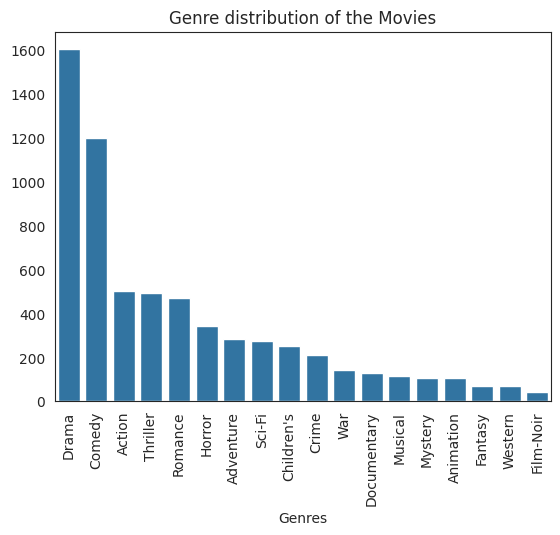

In [13]:
# Convert the Release_year datatype to int
df_movies.Release_year = df_movies.Release_year.astype('int')

# Plot the Genre distribution of the Movies
genre_counts = df_movies['Genres'].value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title("Genre distribution of the Movies")
plt.xticks(rotation=90)
plt.show()

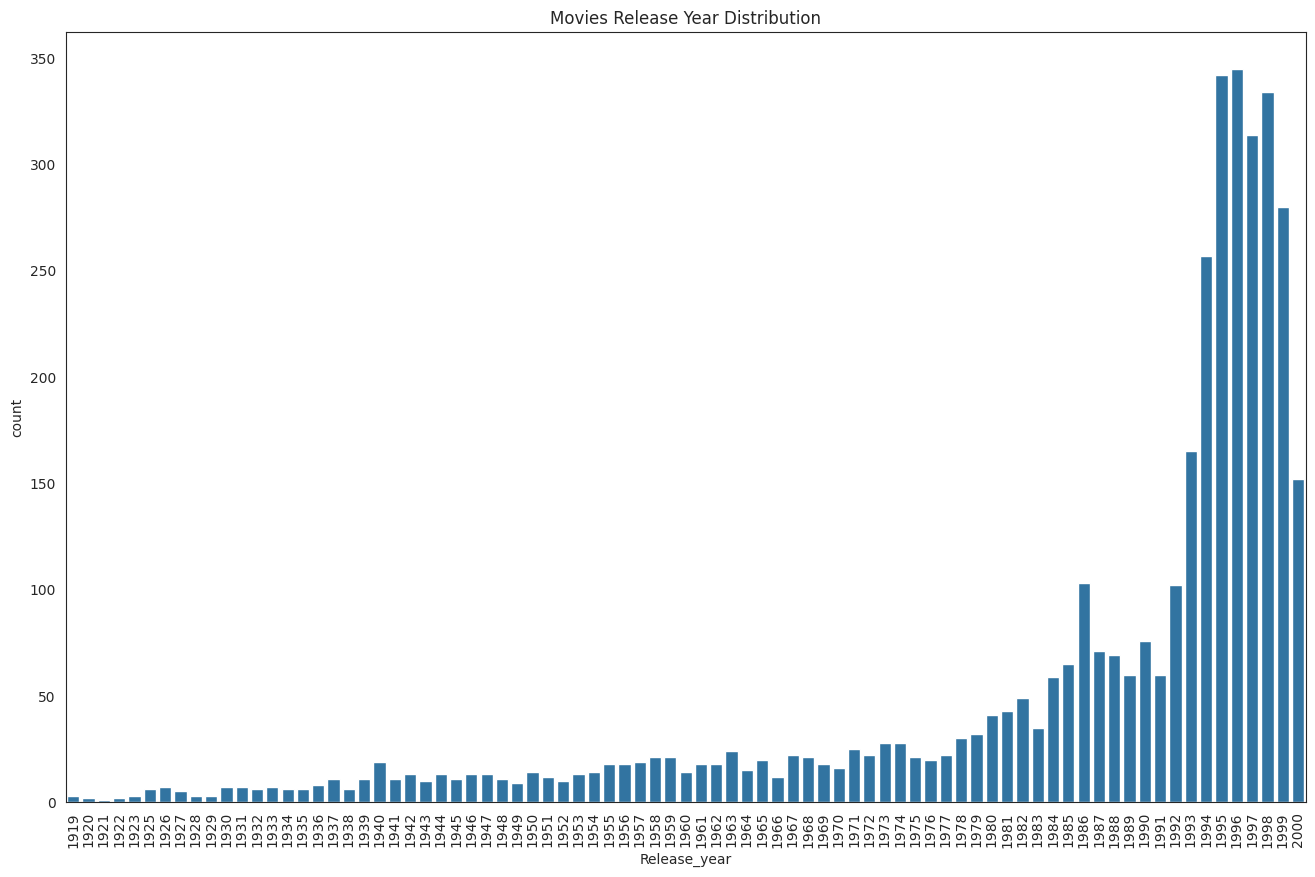

In [14]:
# Plot the Release Year distribution of the Movies

plt.figure(figsize=(16,10))
sns.countplot(df_movies.groupby('Title').agg({'Release_year':'first'}), x='Release_year')
plt.title("Movies Release Year Distribution")
plt.xticks(rotation=90)
plt.show()

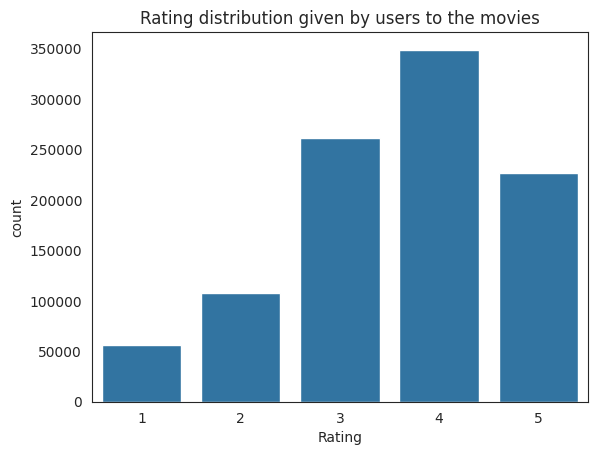

In [15]:
# Plot the Ratings distribution

sns.countplot(df_ratings, x='Rating')
plt.title("Rating distribution given by users to the movies")
plt.show()

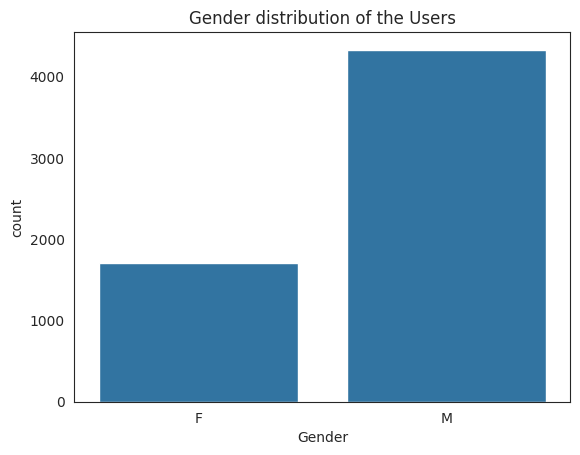

In [16]:
# Plot the Gender distribution of the users

sns.countplot(df_users, x='Gender')
plt.title("Gender distribution of the Users")
plt.show()

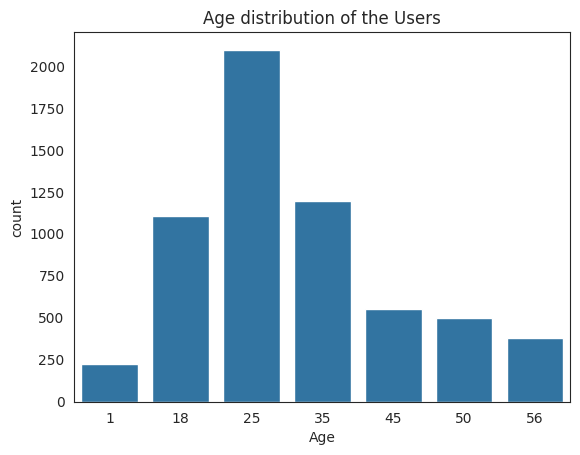

In [17]:
# Plot the Age distribution of the users

sns.countplot(df_users, x='Age')
plt.title("Age distribution of the Users")
plt.show()

In [18]:
# Replace numerical codes with categorical values for Occupation
occupation_mapping = {
0: 'Other or not specified',
1: 'Academic/Educator',
2: 'Artist',
3: 'Clerical/Admin',
4: 'College/Grad Student',
5: 'Customer Service',
6: 'Doctor/Health Care',
7: 'Executive/Managerial',
8: 'Farmer',
9: 'Homemaker',
10: 'K-12 Student',
11: 'Lawyer',
12: 'Programmer',
13: 'Retired',
14: 'Sales/Marketing',
15: 'Scientist',
16: 'Self-Employed',
17: 'Technician/Engineer',
18: 'Tradesman/Craftsman',
19: 'Unemployed',
20: 'Writer'
}
df_users['Occupation'] = df_users['Occupation'].replace(occupation_mapping)

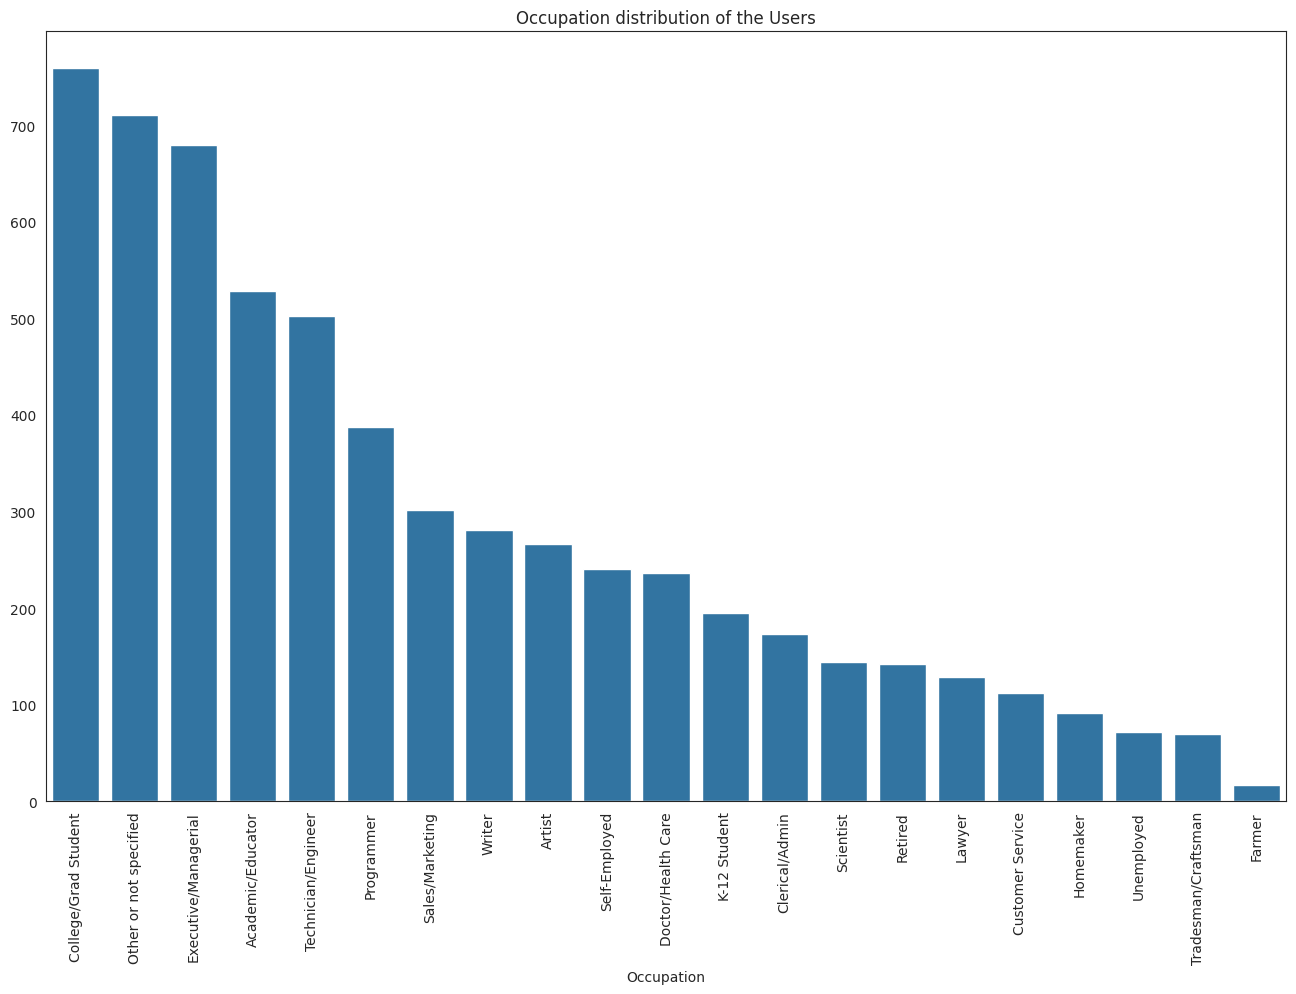

In [19]:
# Plot the Occupation distribution of the users
occupation_counts = df_users['Occupation'].value_counts()
plt.figure(figsize=(16,10))
sns.barplot(x=occupation_counts.index, y=occupation_counts.values)
plt.xticks(rotation=90)
plt.title("Occupation distribution of the Users")
plt.show()

In [20]:
# Merging all the datasets

df = pd.merge(pd.merge(df_movies, df_ratings, left_on = 'Movie ID', right_on = 'MovieID',how='inner'), df_users, on = 'UserID', how = 'inner')

In [21]:
df.head()

Movie ID      Title     Genres  Release_year  UserID  MovieID  Rating  \
0         1  Toy Story  Animation          1995       1        1       5   
1         1  Toy Story  Animation          1995       6        1       4   
2         1  Toy Story  Animation          1995       8        1       4   
3         1  Toy Story  Animation          1995       9        1       5   
4         1  Toy Story  Animation          1995      10        1       5   

   Timestamp Gender  Age           Occupation Zip-code  
0  978824268      F    1         K-12 Student    48067  
1  978237008      F   50            Homemaker    55117  
2  978233496      M   25           Programmer    11413  
3  978225952      M   25  Technician/Engineer    61614  
4  978226474      F   35    Academic/Educator    95370

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101815 entries, 0 to 2101814
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Movie ID      int64 
 1   Title         object
 2   Genres        object
 3   Release_year  int64 
 4   UserID        int64 
 5   MovieID       int64 
 6   Rating        int64 
 7   Timestamp     int64 
 8   Gender        object
 9   Age           int64 
 10  Occupation    object
 11  Zip-code      object
dtypes: int64(7), object(5)
memory usage: 192.4+ MB


In [23]:
df.describe()

Movie ID  Release_year     UserID    MovieID     Rating     Timestamp  \
count 2101815.00    2101815.00 2101815.00 2101815.00 2101815.00    2101815.00   
mean     1777.77       1986.72    3026.20    1777.77       3.58  971999332.39   
std      1069.83         14.08    1731.01    1069.83       1.12   11808640.09   
min         1.00       1919.00       1.00       1.00       1.00  956703932.00   
25%       942.00       1982.00    1505.00     942.00       3.00  965278046.00   
50%      1645.00       1992.00    3075.00    1645.00       4.00  972782918.00   
75%      2640.00       1997.00    4478.00    2640.00       4.00  975181937.00   
max      3952.00       2000.00    6040.00    3952.00       5.00 1046454590.00   

             Age  
count 2101815.00  
mean       29.61  
std        11.73  
min         1.00  
25%        25.00  
50%        25.00  
75%        35.00  
max        56.00

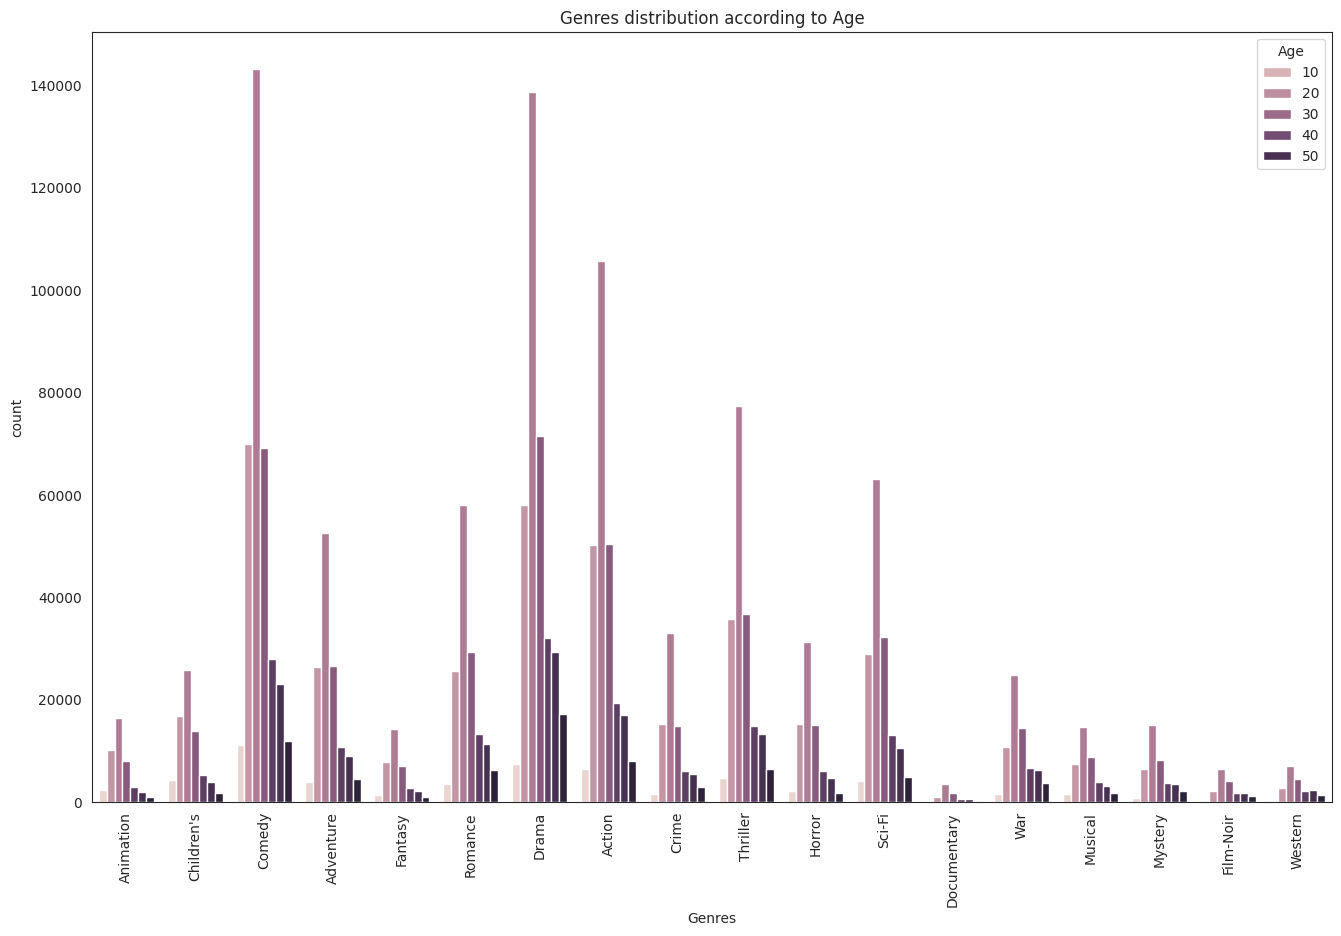

In [24]:
# Plot the age and genre relationship

plt.figure(figsize=(16,10))
sns.countplot(df, x='Genres', hue='Age')
plt.xticks(rotation=90)
plt.title("Genres distribution according to Age")
plt.show()

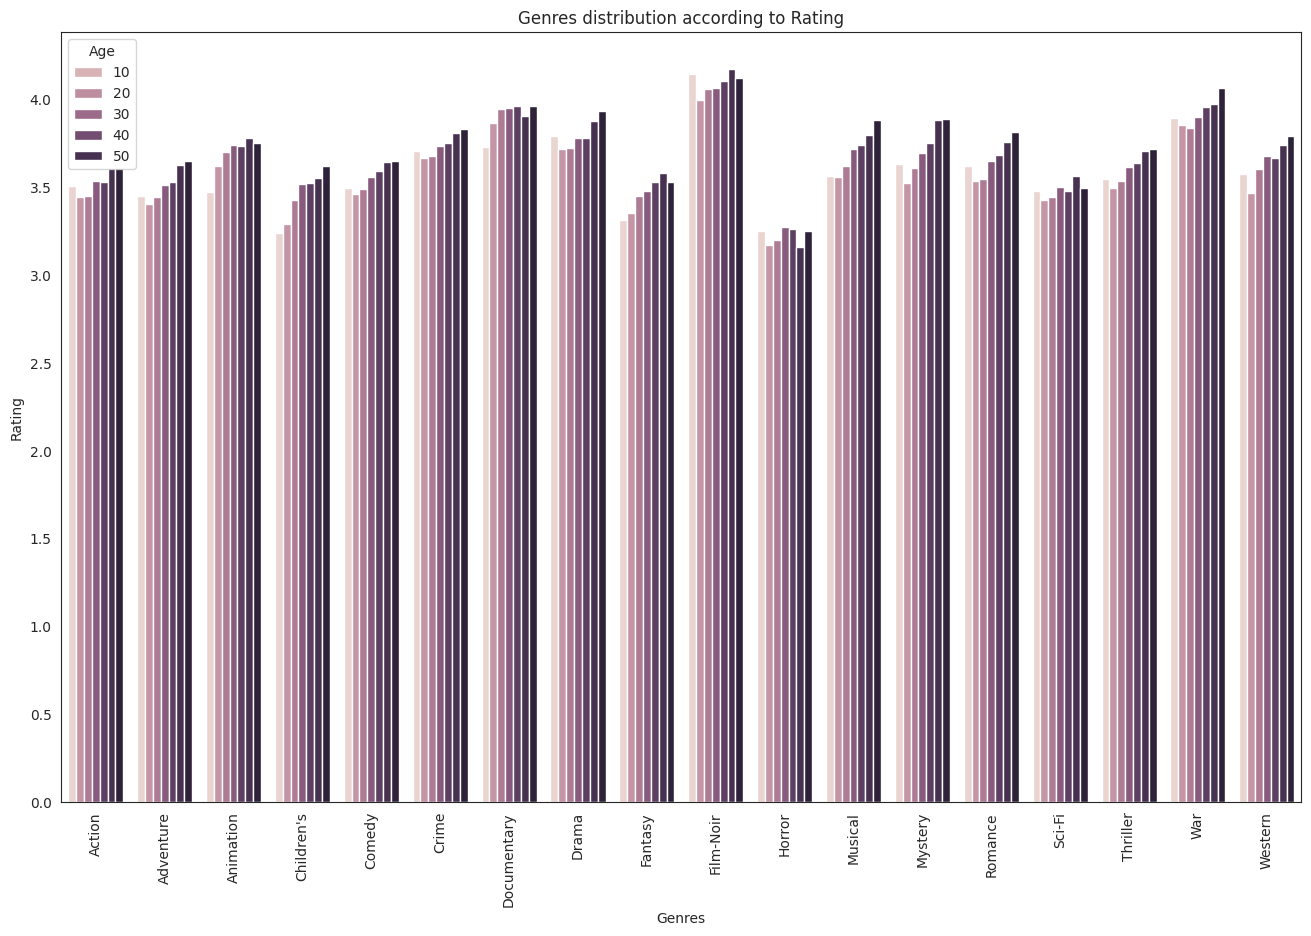

In [25]:
avg_genre_age_rating = df.groupby(['Genres','Age']).agg({'Rating':'mean'}).reset_index()

# Plot the age and genre relationship
plt.figure(figsize=(16,10))
sns.barplot(avg_genre_age_rating, x='Genres', y='Rating', hue='Age')
plt.xticks(rotation=90)
plt.title("Genres distribution according to Rating")
plt.show()

In [26]:
def missing_values(df):
    total_null = df.isnull().sum().sort_values(ascending  = False)
    percent_null = ((df.isnull().sum()/df.shape[0])*100).sort_values(ascending = False)
    print(f"Total records in our data =  {df.shape[0]} where missing values are as follows:")
    missing_data = pd.concat([total_null, percent_null.round(2)], axis = 1,keys=['Total Missing','In Percent'])
    return missing_data

missing_values(df)

Total records in our data =  2101815 where missing values are as follows:


Total Missing  In Percent
Movie ID                  0        0.00
Title                     0        0.00
Genres                    0        0.00
Release_year              0        0.00
UserID                    0        0.00
MovieID                   0        0.00
Rating                    0        0.00
Timestamp                 0        0.00
Gender                    0        0.00
Age                       0        0.00
Occupation                0        0.00
Zip-code                  0        0.00

In [27]:
duplicates = df[df.duplicated()]
print('The number of duplicates rows:', duplicates.shape[0])

The number of duplicates rows: 0


In [28]:
# Keep the unique datapoints only
df = df.drop_duplicates(subset=['MovieID',"Title","UserID",'Timestamp','Release_year']).reset_index(drop = True)

print(f"Final merged Dataframe = {df.shape}")

Final merged Dataframe = (1000209, 12)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Movie ID      1000209 non-null  int64 
 1   Title         1000209 non-null  object
 2   Genres        1000209 non-null  object
 3   Release_year  1000209 non-null  int64 
 4   UserID        1000209 non-null  int64 
 5   MovieID       1000209 non-null  int64 
 6   Rating        1000209 non-null  int64 
 7   Timestamp     1000209 non-null  int64 
 8   Gender        1000209 non-null  object
 9   Age           1000209 non-null  int64 
 10  Occupation    1000209 non-null  object
 11  Zip-code      1000209 non-null  object
dtypes: int64(7), object(5)
memory usage: 91.6+ MB


In [30]:
df['Age'] = df['Age'].astype('int32')
df['Rating'] = df['Rating'].astype('int32')
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
#df['ReleaseYear'] = df['Title'].str.rsplit(" ",1).str[1].str.lstrip('(').str.rstrip(')')
df.replace({'Age':{1: "Under 18",
                   18: "18-24",
                   25: "25-34",
                   35: "35-44",
                   45: "45-49",
                   50: "50-55",
                   56: "56+"}},inplace=True)
df.replace({'Occupation':{'0': "other" or not specified,
                          '1': "academic/educator",
                          '2': "artist",
                          '3': "clerical/admin",
                          '4': "college/grad student",
                          '5': "customer service",
                          '6': "doctor/health care",
                          '7': "executive/managerial",
                          '8': "farmer",
                          '9': "homemaker",
                          '10': "K-12 student",
                          '11': "lawyer",
                          '12': "programmer",
                          '13': "retired",
                          '14': "sales/marketing",
                          '15': "scientist",
                          '16': "self-employed",
                          '17': "technician/engineer",
                          '18': "tradesman/craftsman",
                          '19': "unemployed",
                          '20': "writer"

}},inplace=True)

In [31]:
# Find the movie with maximum number of Ratings
df.groupby(['Title', 'MovieID']).agg({'Rating':'count'}).reset_index().sort_values('Rating', ascending=False)

Title  MovieID  Rating
127                                     American Beauty     2858    3428
3153                 Star Wars: Episode IV - A New Hope      260    2991
3154     Star Wars: Episode V - The Empire Strikes Back     1196    2990
3155         Star Wars: Episode VI - Return of the Jedi     1210    2883
1789                                      Jurassic Park      480    2672
...                                                 ...      ...     ...
3274                                             Target      139       1
1625  I Don't Want to Talk About It (De eso no se ha...      584       1
156                             An Unforgettable Summer      790       1
2343                                  Never Met Picasso     1714       1
1276                                         Full Speed     1724       1

[3706 rows x 3 columns]

In [32]:
# Group the Dataframe according to the average Rating of the movies and their number of ratings

title_details = df.groupby(['MovieID', 'Title']).agg({'Rating':['mean', 'count']}).reset_index()
title_details.columns = ['MovieID', 'Title', 'Rating Avg', 'Rating Count']
title_details['Rating Avg'] = title_details['Rating Avg'].round(2)
title_details

MovieID                        Title  Rating Avg  Rating Count
0           1                    Toy Story        4.15          2077
1           2                      Jumanji        3.20           701
2           3             Grumpier Old Men        3.02           478
3           4            Waiting to Exhale        2.73           170
4           5  Father of the Bride Part II        3.01           296
...       ...                          ...         ...           ...
3701     3948             Meet the Parents        3.64           862
3702     3949          Requiem for a Dream        4.12           304
3703     3950                    Tigerland        3.67            54
3704     3951             Two Family House        3.90            40
3705     3952               Contender, The        3.78           388

[3706 rows x 4 columns]

In [33]:
#Pivot Table UserID vs Movie Title
# Copy the merged final dataframe into new

df_copy = df.copy()
df_copy.sample(10)

Movie ID                                       Title     Genres  \
585186      2125              Ever After: A Cinderella Story      Drama   
338929      1242                                       Glory     Action   
28578         70                         From Dusk Till Dawn     Action   
752480      2789                             Damien: Omen II     Horror   
886361      3362                           Dog Day Afternoon     Comedy   
856776      3203                                   Dead Calm   Thriller   
516425      1923                There's Something About Mary     Comedy   
271622      1094                            Crying Game, The      Drama   
313693      1210  Star Wars: Episode VI - Return of the Jedi     Action   
719800      2687                                      Tarzan  Animation   

        Release_year  UserID  MovieID  Rating           Timestamp Gender  \
585186          1998    5312     2125       2 2000-06-13 19:21:29      M   
338929          1989    2122     1242       5 2000-12-13 23:48:10      M   
28578           1996    3475       70       3 2000-11-21 03:29:59      M   
752480          1978    2094     2789       3 2000-11-19 17:01:00      M   
886361          1975    3490     3362       4 2000-08-23 16:56:23      M   
856776          1989    2669     3203       3 2000-11-05 17:01:26      M   
516425          1998    5083     1923       5 2000-07-01 15:18:26      M   
271622          1992     911     1094       4 2000-11-26 11:24:49      M   
313693          1983    1752     1210       5 2000-12-02 03:53:11      M   
719800          1999    2621     2687       2 2000-11-08 03:52:02      M   

          Age              Occupation Zip-code  
585186  25-34       Academic/Educator    10463  
338929  35-44              Programmer    61614  
28578   25-34         Sales/Marketing    33133  
752480  35-44                  Artist    60061  
886361  25-34  Other or not specified    74136  
856776  45-49  Other or not specified    24541  
516425  25-34    College/Grad Student    16803  
271622  50-55  Other or not specified    98226  
313693  25-34          Clerical/Admin    96813  
719800  18-24  Other or not specified    46304

In [34]:
# Create a pivot table of UserID as index, titles as columns, and values as ratings
pivot_table = pd.pivot_table(df_copy, values='Rating', index='UserID', columns='Title', fill_value=0)

# Display the pivot tab
pivot_table.head()

Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                  0.00           0.00                0.00         0.00   
2                  0.00           0.00                0.00         0.00   
3                  0.00           0.00                0.00         0.00   
4                  0.00           0.00                0.00         0.00   
5                  0.00           0.00                0.00         0.00   

Title   ...And Justice for All  1-900  10 Things I Hate About You  \
UserID                                                              
1                         0.00   0.00                        0.00   
2                         0.00   0.00                        0.00   
3                         0.00   0.00                        0.00   
4                         0.00   0.00                        0.00   
5                         0.00   0.00                        0.00   

Title   101 Dalmatians  12 Angry Men  13th Warrior, The  187  \
UserID                                                         
1                 0.00          0.00               0.00 0.00   
2                 0.00          0.00               0.00 0.00   
3                 0.00          0.00               0.00 0.00   
4                 0.00          0.00               0.00 0.00   
5                 0.00          0.00               0.00 0.00   

Title   2 Days in the Valley  20 Dates  20,000 Leagues Under the Sea  \
UserID                                                                 
1                       0.00      0.00                          0.00   
2                       0.00      0.00                          0.00   
3                       0.00      0.00                          0.00   
4                       0.00      0.00                          0.00   
5                       0.00      0.00                          0.00   

Title   200 Cigarettes  2001: A Space Odyssey  2010  24 7: Twenty Four Seven  \
UserID                                                                         
1                 0.00                   0.00  0.00                     0.00   
2                 0.00                   0.00  0.00                     0.00   
3                 0.00                   0.00  0.00                     0.00   
4                 0.00                   0.00  0.00                     0.00   
5                 0.00                   0.00  0.00                     0.00   

Title   24-hour Woman  28 Days  3 Ninjas: High Noon On Mega Mountain  \
UserID                                                                 
1                0.00     0.00                                  0.00   
2                0.00     0.00                                  0.00   
3                0.00     3.00                                  0.00   
4                0.00     0.00                                  0.00   
5                0.00     0.00                                  0.00   

Title   3 Strikes  301, 302  39 Steps, The  \
UserID                                       
1            0.00      0.00           0.00   
2            0.00      0.00           0.00   
3            0.00      0.00           0.00   
4            0.00      0.00           0.00   
5            0.00      0.00           0.00   

Title   400 Blows, The (Les Quatre cents coups)  42 Up  52 Pick-Up   54  \
UserID                                                                    
1                                          0.00   0.00        0.00 0.00   
2                                          0.00   0.00        0.00 0.00   
3                                          0.00   0.00        0.00 0.00   
4                                          0.00   0.00        0.00 0.00   
5                                          0.00   0.00        0.00 1.00   

Title   7th Voyage of Sinbad, The  8 1/2  8 1/2 Women  \
UserID                                                  
1      

In [35]:
# Calculate the Sparsity
print(f"Sparsity = {round((pivot_table.sum().sum())/pivot_table.size*100,2)}%")

print(f"Pivot table shape = {pivot_table.shape}")

Sparsity = 16.14%
Pivot table shape = (6040, 3664)


In [36]:
#Pearson Correlation Approach for item-based approach
# Find the movies similar to 'Liar Liar'

movie_input = input("Enter the movie name")
movie_rating = pivot_table[movie_input]

# Store the related movies correlation matrix with that of the movie_inp
related_movies = pivot_table.corrwith(movie_rating)


Enter the movie nameEver After: A Cinderella Story


In [37]:
# Sort the related values
related_movies.sort_values(ascending=False).iloc[1:].head()

Title
Circle of Friends          0.34
Practical Magic            0.33
My Best Friend's Wedding   0.32
Notting Hill               0.31
You've Got Mail            0.31
dtype: float64

In [38]:
#Item-item similarity

# Create a pivot table of movies and user ratings
pivot_table_cos = pd.pivot_table(df_copy, values='Rating', index='UserID', columns='Title', fill_value=0)

# Calculate cosine similarity for item-item similarity based on movie titles
item_similarity = cosine_similarity(pivot_table_cos.T)

In [39]:
# Create a dataframe of item-item similarity
item_similarity_df = pd.DataFrame(item_similarity, index=pivot_table_cos.columns, columns = pivot_table_cos.columns)

# Display the item-item similarity dataframe
item_similarity_df.head()

Title                   $1,000,000 Duck  'Night Mother  'Til There Was You  \
Title                                                                        
$1,000,000 Duck                    1.00           0.07                0.04   
'Night Mother                      0.07           1.00                0.12   
'Til There Was You                 0.04           0.12                1.00   
'burbs, The                        0.08           0.12                0.10   
...And Justice for All             0.06           0.16                0.07   

Title                   'burbs, The  ...And Justice for All  1-900  \
Title                                                                
$1,000,000 Duck                0.08                    0.06   0.00   
'Night Mother                  0.12                    0.16   0.00   
'Til There Was You             0.10                    0.07   0.08   
'burbs, The                    1.00                    0.14   0.00   
...And Justice for All         0.14                    1.00   0.00   

Title                   10 Things I Hate About You  101 Dalmatians  \
Title                                                                
$1,000,000 Duck                               0.06            0.19   
'Night Mother                                 0.08            0.14   
'Til There Was You                            0.13            0.13   
'burbs, The                                   0.19            0.25   
...And Justice for All                        0.08            0.18   

Title                   12 Angry Men  13th Warrior, The  187  \
Title                                                          
$1,000,000 Duck                 0.09               0.06 0.03   
'Night Mother                   0.11               0.05 0.06   
'Til There Was You              0.08               0.07 0.02   
'burbs, The                     0.17               0.20 0.10   
...And Justice for All          0.21               0.12 0.11   

Title                   2 Days in the Valley  20 Dates  \
Title                                                    
$1,000,000 Duck                         0.02      0.02   
'Night Mother                           0.11      0.04   
'Til There Was You                      0.07      0.09   
'burbs, The                             0.18      0.05   
...And Justice for All                  0.20      0.04   

Title                   20,000 Leagues Under the Sea  200 Cigarettes  \
Title                                                                  
$1,000,000 Duck                                 0.14            0.09   
'Night Mother                                   0.07            0.14   
'Til There Was You                              0.03            0.20   
'burbs, The                                     0.19            0.24   
...And Justice for All                          0.17            0.11   

Title                   2001: A Space Odyssey  2010  24 7: Twenty Four Seven  \
Title                                                                          
$1,000,000 Duck                          0.07  0.04                     0.00   
'Night Mother                            0.10  0.08                     0.06   
'Til There Was You                       0.06  0.04                     0.00   
'burbs, The                              0.20  0.19                     0.00   
...And Justice for All                   0.22  0.15                     0.08   

Title                   24-hour Woman  28 Days  \
Title                                            
$1,000,000 Duck                  0.00     0.06   
'Night Mother                    0.06     0.06   
'Til There Was You               0.17     0.12   
'burbs, The                      0.04     0.12   
...And Justice for All           0.02     0.09   

Title                   3 Ninjas: High Noon On Mega Mountain  3 Strikes  \
Title                                                                     
$1,000,000 Duck                                 

In [40]:
#User-User Similarity

# Calculate cosine similarity for user-user similarity based on user ratings
user_similarity = cosine_similarity(pivot_table_cos)

# Create a dataframe of user-user similarity
user_similarity_df = pd.DataFrame(user_similarity, index=pivot_table_cos.index, columns = pivot_table_cos.index)

# Display the user-user similarity dataframe
user_similarity_df.head()

UserID  1     2     3     4     5     6     7     8     9     10    11    \
UserID                                                                     
1       1.00  0.10  0.12  0.13  0.09  0.18  0.06  0.14  0.23  0.25  0.13   
2       0.10  1.00  0.15  0.17  0.11  0.10  0.31  0.21  0.19  0.23  0.20   
3       0.12  0.15  1.00  0.15  0.06  0.07  0.14  0.08  0.13  0.21  0.17   
4       0.13  0.17  0.15  1.00  0.05  0.01  0.13  0.10  0.09  0.12  0.07   
5       0.09  0.11  0.06  0.05  1.00  0.05  0.13  0.22  0.26  0.12  0.22   

UserID  12    13    14    15    16    17    18    19    20    21    22    \
UserID                                                                     
1       0.11  0.12  0.07  0.09  0.04  0.13  0.25  0.22  0.03  0.12  0.09   
2       0.10  0.32  0.09  0.31  0.00  0.25  0.24  0.21  0.19  0.03  0.23   
3       0.08  0.28  0.07  0.20  0.05  0.12  0.22  0.22  0.05  0.08  0.19   
4       0.07  0.20  0.06  0.11  0.00  0.15  0.19  0.20  0.11  0.05  0.10   
5       0.04  0.12  0.14  0.21  0.08  0.22  0.15  0.16  0.14  0.07  0.18   

UserID  23    24    25    26    27    28    29    30    31    32    33    \
UserID                                                                     
1       0.10  0.17  0.14  0.12  0.05  0.17  0.05  0.21  0.06  0.08  0.19   
2       0.18  0.19  0.18  0.20  0.09  0.20  0.20  0.15  0.08  0.14  0.28   
3       0.10  0.22  0.17  0.16  0.13  0.23  0.16  0.08  0.18  0.05  0.23   
4       0.13  0.10  0.22  0.10  0.10  0.21  0.36  0.12  0.06  0.04  0.19   
5       0.24  0.15  0.13  0.08  0.10  0.16  0.08  0.21  0.04  0.18  0.18   

UserID  34    35    36    37    38    39    40    41    42    43    44    \
UserID                                                                     
1       0.16  0.11  0.16  0.07  0.13  0.11  0.05  0.13  0.10  0.11  0.21   
2       0.11  0.16  0.22  0.12  0.08  0.09  0.09  0.13  0.21  0.07  0.19   
3       0.13  0.12  0.23  0.10  0.03  0.08  0.17  0.12  0.25  0.14  0.27   
4       0.05  0.11  0.19  0.04  0.00  0.04  0.08  0.13  0.24  0.00  0.15   
5       0.10  0.12  0.21  0.05  0.09  0.27  0.04  0.05  0.11  0.09  0.10   

UserID  45    46    47    48    49    50    51    52    53    54    55    \
UserID                                                                     
1       0.11  0.00  0.13  0.25  0.21  0.02  0.12  0.04  0.17  0.09  0.15   
2       0.10  0.00  0.11  0.31  0.22  0.10  0.08  0.25  0.25  0.03  0.18   
3       0.10  0.01  0.01  0.24  0.14  0.06  0.05  0.12  0.12  0.20  0.07   
4       0.00  0.00  0.00  0.18  0.16  0.03  0.00  0.06  0.15  0.04  0.00   
5       0.09  0.00  0.11  0.20  0.13  0.06  0.15  0.08  0.27  0.01  0.12   

UserID  56    57    58    59    60    61    62    63    64    65    66    \
UserID                                                                     
1       0.20  0.07  0.19  0.17  0.05  0.03  0.13  0.05  0.07  0.18  0.12   
2       0.14  0.11  0.26  0.22  0.14  0.03  0.23  0.07  0.13  0.27  0.22   
3       0.09  0.12  0.20  0.10  0.06  0.00  0.15  0.04  0.16  0.22  0.18   
4       0.04  0.08  0.20  0.09  0.00  0.00  0.12  0.03  0.16  0.21  0.13   
5       0.31  0.11  0.25  0.18  0.07  0.03  0.14  0.25  0.10  0.13  0.05   

UserID  67    68    69    70    71    72    73    74    75    76    77    \
UserID                                                                     
1       0.11  0.16  0.03  0.09  0.06  0.10  0.12  0.06  0.21  0.13  0.04   
2       0.22  0.06  0.16  0.06  0.07  0.21  0.24  0.06  0.06  0.16  0.06   
3       0.02  0.18  0.07  0.10  0.11  0.12  0.26  0.05  0.07  0.05  0.06   
4       0.05  0.02  0.05  0.03  0.11  0.11  0.13  0.00  0.05  0.06  0.00   
5       0.09  0.13  0.21  0.24  0.09  0.12  0.17  0.16  0.08  0.27  0.22   

UserID  78    79    80    81    82    83    84    85    86    87    88    \
UserID                                                                     
1       0.17  0.02  0.30  0.07  0.13  0.15  0.11  0.07  0.10  0.06  0.15   
2       0.09  0.04  0.28  0.12  0.29  0.0

In [43]:
# Create a sparse matrix using the CSR format
sparse_matrix = csr_matrix(pivot_table_cos.T.values)

# Fit the Nearest Neighbors model using Cosine Similarity
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_matrix)

# Get input movie name from the user
movie_name = input("Enter the name of a movie: ")

# Find the index of the input movie in the pivot table
movie_index = pivot_table_cos.columns.get_loc(movie_name)

# Find the 6 nearest neighbors (including the input movie itself)
distances, indices = model.kneighbors(sparse_matrix[movie_index], n_neighbors=6)

# Get the indices of the recommended movies (excluding the input movie itself)
recommended_indices = indices.flatten()[1:]

# Get the titles of the recommended movies
recommended_movies = pivot_table_cos.columns[recommended_indices]

# Display the top 5 recommended movies
print("Top 5 recommended movies similar to", movie_name)
for i, movie in enumerate(recommended_movies[:5], 1):
    print(i, "-", movie)

Enter the name of a movie: There's Something About Mary
Top 5 recommended movies similar to There's Something About Mary
1 - Wayne's World
2 - Austin Powers: International Man of Mystery
3 - Groundhog Day
4 - As Good As It Gets
5 - Full Monty, The


In [46]:
# install cmfrec library
!pip install cmfrec

  Using cached cmfrec-3.5.1.post10.tar.gz (268 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post10-cp310-cp310-linux_x86_64.whl size=5669623 sha256=447b210be27675384ee4ccd15c2992fb2d00d93a010f710b609f55499cdcc750
  Stored in directory: /root/.cache/pip/wheels/cc/80/d7/9b7d9361970eb499c0227a3fac504240f7793dec0d9793bee6
Successfully built cmfrec


In [49]:
from cmfrec import CMF
# Step 1: Install the required library

# Step 2: Load and preprocess the data
# Assuming you have a DataFrame named df_copy with columns UserID, MovieID, Rating
data = df_copy[['UserID', 'MovieID', 'Rating']]

# Step 3: Rename columns to match the expected format by CMF model
data.rename(columns={'UserID': 'UserId', 'MovieID': 'ItemId'}, inplace=True)

# Step 4: Split the data into training and testing sets for Matrix Factorization
train_data, test_data = train_test_split(data, test_size=0.2, random_state=21)

# Step 5: Train the Matrix Factorization model with d=4 embeddings
model = CMF(k=4, random_state=21, niter=100)
model.fit(train_data)

Collective matrix factorization model
(explicit-feedback variant)


In [50]:
# Step 6: Evaluate the model's performance using RMSE and MAPE
predictions = []
for _, row in test_data.iterrows():
    user_id, item_id = row['UserId'], row['ItemId']
    pred_rating = model.predict(user=user_id, item=item_id)
    pred_rating = round(pred_rating.item(),2)
    predictions.append(pred_rating)

predictions = np.array(predictions)
rmse = np.sqrt(np.mean((test_data['Rating'] - predictions)**2))
mape = np.mean(np.abs(test_data['Rating'] - predictions) / test_data['Rating']) * 100
print("RMSE:", rmse)
print("MAPE:", mape)

RMSE: 0.8605430325060643
MAPE: 26.207263807933668


In [51]:
# Step 7: Use the learned embeddings for visualization and similarity-based models
user_embeddings = model.A_
item_embeddings = model.B_

# Step 8: Redesign item-item and user-user similarity functions using MF embeddings
# For example, to compute cosine similarity between item embeddings
def item_item_similarity(item_id_1, item_id_2):
    emb_1 = item_embeddings[item_id_1]
    emb_2 = item_embeddings[item_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Similarly, compute user-user similarity using MF embeddings
def user_user_similarity(user_id_1, user_id_2):
    emb_1 = user_embeddings[user_id_1]
    emb_2 = user_embeddings[user_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

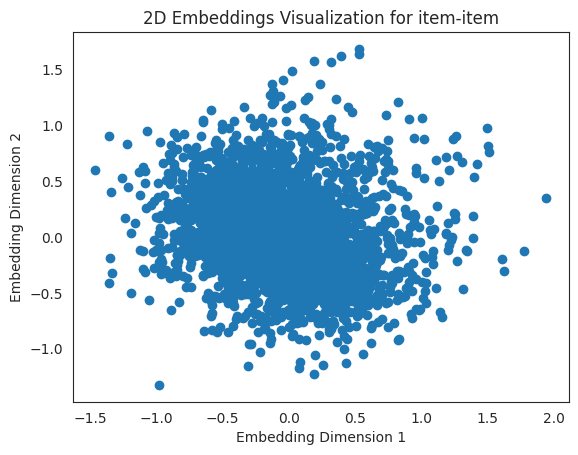

In [52]:
# Get d=2 embeddings and plot the results
model_2d = CMF(k=2, random_state=42, niter=100)
model_2d.fit(train_data)
item_embeddings_2d = model_2d.B_
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('2D Embeddings Visualization for item-item')
plt.show()

In [53]:
# Step 1: Install Surprise library
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357287 sha256=0c666637b57da0f9158daf4661532027b392375f0cd4dfa8fc543382fe2821c2
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [54]:
# Step 2: Import necessary modules from Surprise
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# Step 3: Load your dataset into Surprise
# Assuming you have a DataFrame named final_df_copy with columns UserID, MovieID, a
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_copy[['UserID', 'MovieID', 'Rating']], reader)
# Step 4: Split the data into training and testing sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
# Step 5: Train the Matrix Factorization model (SVD) on the training set
model = SVD(n_factors=4, random_state=42)
model.fit(train_set)
# Step 6: Make predictions on the test set
predictions = model.test(test_set)
# Step 7: Evaluate the model's performance using RMSE
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)

RMSE: 0.8816
RMSE: 0.8815638714983941


In [55]:
# Step 12: Make predictions using the trained SVD model
predictions = [model.predict(uid, iid, r_ui_trans) for (uid, iid, r_ui_trans) in test_set]
# Step 13: Compute absolute percentage error for each prediction
absolute_percentage_errors = []
for prediction in predictions:
    actual_rating = prediction.r_ui
    predicted_rating = prediction.est
    absolute_percentage_error = abs((actual_rating - predicted_rating) / actual_rating)
    absolute_percentage_errors.append(absolute_percentage_error)
# Step 14: Calculate MAPE
mape = np.mean(absolute_percentage_errors)
print("MAPE:", mape)

MAPE: 0.2691983156078118


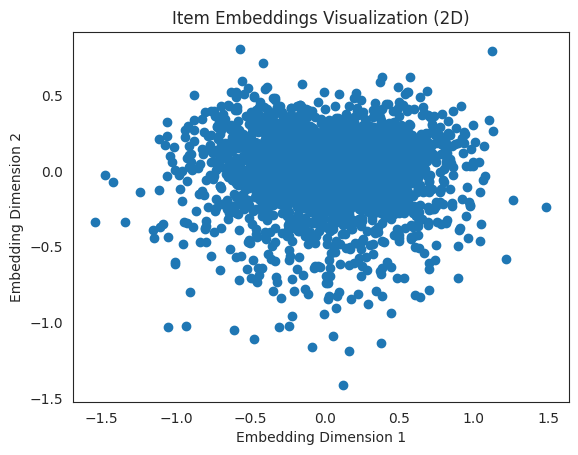

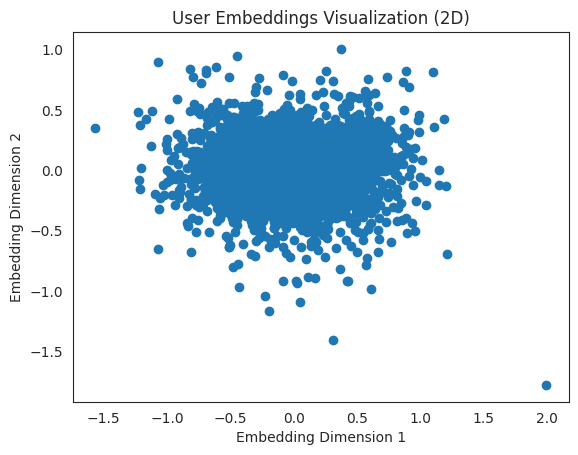

In [56]:
from sklearn.decomposition import PCA

# Step 8: Extract item and user embeddings from the trained SVD model
item_embeddings = model.qi
user_embeddings = model.pu

# Step 9: Redesign item-item similarity function using MF embeddings
def item_item_similarity(item_id_1, item_id_2):
    emb_1 = item_embeddings[item_id_1]
    emb_2 = item_embeddings[item_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Step 10: Redesign user-user similarity function using MF embeddings
def user_user_similarity(user_id_1, user_id_2):
    emb_1 = user_embeddings[user_id_1]
    emb_2 = user_embeddings[user_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Step 11: Get d=2 embeddings and plot the results
pca = PCA(n_components=2)
item_embeddings_2d = pca.fit_transform(item_embeddings)
user_embeddings_2d = pca.fit_transform(user_embeddings)

# Plot item embeddings in 2D
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Item Embeddings Visualization (2D)')
plt.show()

# Plot user embeddings in 2D
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('User Embeddings Visualization (2D)')
plt.show()